# Classification for Cassava Disease Classification using TF/Keras

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization,Lambda, GlobalAveragePooling2D, Concatenate, Lambda
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay, NoisyLinearCosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.preprocessing.image import load_img
from random import uniform
from keras.utils import to_categorical

This notebook presents a full pipeline to load the data, train a neural network and use the model to predict over the test images. To make it possible to run within the allocated time for notebooks, this notebook will only present a single fold with a split of 80% for training and 20% for validation.

In [3]:
training_folder = '../input/cassava-leaf-disease-classification/train_images/'

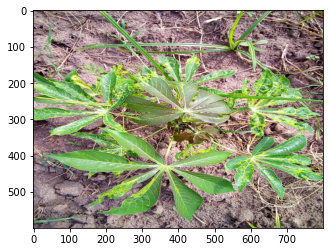

In [4]:
img = Image.open("../input/cassava-leaf-disease-classification/train_images/1277648239.jpg")
plt.imshow(img)
plt.show()

# Prepare the training and validation data generators

In [5]:
samples_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
samples_df = shuffle(samples_df, random_state=42)
samples_df["filepath"] = training_folder+samples_df["image_id"]
samples_df[:10]

,image_id,label,filepath
9134,2615227158.jpg,4,../input/cassava-leaf-disease-classification/t...
1580,1277648239.jpg,3,../input/cassava-leaf-disease-classification/t...
7304,2305895487.jpg,3,../input/cassava-leaf-disease-classification/t...
13196,336299725.jpg,2,../input/cassava-leaf-disease-classification/t...
5333,1951270318.jpg,2,../input/cassava-leaf-disease-classification/t...
1453,1254294690.jpg,3,../input/cassava-leaf-disease-classification/t...
1527,1269832262.jpg,3,../input/cassava-leaf-disease-classification/t...
2767,1481899695.jpg,3,../input/cassava-leaf-disease-classification/t...
7895,240469234.jpg,3,../input/cassava-leaf-disease-classification/t...
19003,546602360.jpg,3,../input/cassava-leaf-disease-classification/t...


I keep 80% of the data provided for training and retain the other 20% for validation during my training process.

In [6]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21397 entries, 9134 to 15795
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
 2   filepath  21397 non-null  object
dtypes: int64(1), object(2)
memory usage: 668.7+ KB


In [7]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [8]:
batch_size = 10
image_size = 128
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4
classes_to_predict = sorted(training_df.label.unique())

In [9]:
# One_hot Encoding
y=training_df['label'].values
y = to_categorical(y)

In [10]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

In [11]:
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img,label

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [12]:
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

I also prepare a special dataset that will be fed to the Normalization layer. The EfficientnetB3 provided by tf.keras includes an out-of-the-box Normalization layer fit onto the imagenet dataset. Therefore, we can pull that layer and use the adapt function to refit it to the Cassava Disease dataset.

In [13]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.filepath.values)
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

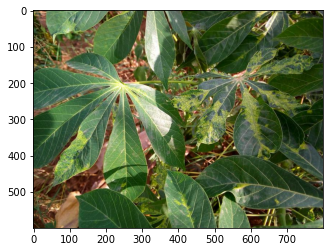

In [14]:
check =("../input/cassava-leaf-disease-classification/train_images/1481899695.jpg")
plt.imshow(adapt_mode(check))

# Build the model

In [17]:
def create_model():
    input_layer = tf.keras.layers.Input(shape=(128,128,3))
    layer = tf.keras.layers.Conv2D(32, (5, 5), strides=2, activation='relu')(input_layer)
    layer = tf.keras.layers.Conv2D(64, (5, 5), strides=2, activation='relu')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    
    layer = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    
    layer = tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu')(layer)
    layer = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    
    layer = tf.keras.layers.GlobalAveragePooling2D()(layer)
    
    layer = tf.keras.layers.Dense(128, activation='relu')(layer)
    layer = tf.keras.layers.Dense(64, activation='relu')(layer)
    
    layer = tf.keras.layers.Dense(5, activation='softmax')(layer)
    model = Model(inputs=input_layer, outputs=layer)
    return model

model = create_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 29, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)       

In [18]:
epochs = 10
decay_steps = int(round(len(training_df)/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)
callbacks = [ModelCheckpoint(filepath='best_cassava_leaf_disease_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-4), metrics=["sparse_categorical_accuracy"])


In [19]:
history = model.fit(training_data_batches,
                  epochs = epochs, 
                  validation_data = validation_data_batches,
                  callbacks = callbacks)

Epoch 1/10
1712/1712 [==============================] - 196s 115ms/step - loss: 0.9157 - sparse_categorical_accuracy: 0.6586 - val_loss: 0.9828 - val_sparse_categorical_accuracy: 0.6465
Epoch 3/10
1712/1712 [==============================] - 196s 115ms/step - loss: 0.8578 - sparse_categorical_accuracy: 0.6758 - val_loss: 0.8313 - val_sparse_categorical_accuracy: 0.7033
Epoch 4/10
1712/1712 [==============================] - 196s 114ms/step - loss: 0.7965 - sparse_categorical_accuracy: 0.7006 - val_loss: 0.7578 - val_sparse_categorical_accuracy: 0.7107
Epoch 5/10
1712/1712 [==============================] - 196s 114ms/step - loss: 0.6841 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.7141 - val_sparse_categorical_accuracy: 0.7451
Epoch 7/10
1712/1712 [==============================] - 196s 114ms/step - loss: 0.6384 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.6074 - val_sparse_categorical_accuracy: 0.7801
Epoch 8/10
1712/1712 [==============================] - 198s 116ms/ste

# Verification of the training process

First, we will check that we perform on similar level on both the training and validation. The training curve will also tell us if we stopped training too early or may have overfitted in comparison to the validation data.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

We load the best weights that were kept from the training phase. Just to check how our model is performing, we will attempt predictions over the validation set. This can help to highlight any classes that will be consistently miscategorised.

In [ ]:
model.load_weights("best_model.h5")

# Prediction on test images

In [36]:
def scan_over_image(img_path, crop_size=128):
    '''
    Will extract 128x128 images covering the whole original image
    with some overlap between images
    '''
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)

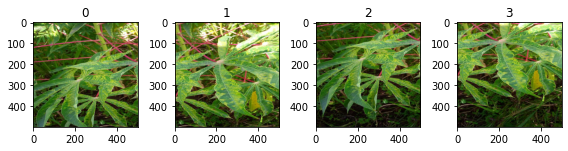

In [37]:
def display_samples(img_path):
    '''
    Display all 128x128 images extracted from original images
    '''
    
    img_list = scan_over_image(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (8,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

display_samples("../input/cassava-leaf-disease-classification/train_images/3412658650.jpg")

In [39]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    '''
    Run the model over 4 local areas of the given image,
    before making a decision depending on the most predicted
    disease.
    '''
    
    #apply TTA to each of the 4 images and sum all predictions for each local image
    localised_predictions = []
    local_image_list = scan_over_image(folder+image_filename)
    for local_image in local_image_list:
        local_image = tf.expand_dims(local_image,0)
        predictions = model.predict(np.array(local_image))
        localised_predictions.append(np.sum(predictions, axis=0))
    
    #sum all predictions from all 4 images and retrieve the index of the highest value
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [40]:
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

First, I test my entire prediction pipeline on the validation set as we have little visibility over the test set.

In [41]:
validation_df["results"] = run_predictions_over_image_list(validation_df["image_id"], training_folder)

100%|██████████| 4280/4280 [18:49<00:00,  3.79it/s]


In [ ]:
!cat ../input/cassava-leaf-disease-classification/label_num_to_disease_map.json

In [43]:
validation_df[:30]

,image_id,label,filepath,results
10234,2824543301.jpg,3,../input/cassava-leaf-disease-classification/t...,3
4763,184909120.jpg,3,../input/cassava-leaf-disease-classification/t...,2
9062,2602456265.jpg,3,../input/cassava-leaf-disease-classification/t...,3
1874,1331491784.jpg,3,../input/cassava-leaf-disease-classification/t...,3
17431,414363375.jpg,3,../input/cassava-leaf-disease-classification/t...,2
13682,3448635186.jpg,3,../input/cassava-leaf-disease-classification/t...,3
20631,84689733.jpg,1,../input/cassava-leaf-disease-classification/t...,3
5831,2038307832.jpg,3,../input/cassava-leaf-disease-classification/t...,3
19329,611582421.jpg,3,../input/cassava-leaf-disease-classification/t...,2
191,1036133928.jpg,3,../input/cassava-leaf-disease-classification/t...,3


In [45]:
from sklearn import metrics

f1_all_cls = metrics.f1_score(validation_df['label'], validation_df['results'], average=None)
f1_macro_avg = metrics.f1_score(validation_df['label'], validation_df['results'], average='weighted')
for i, f1 in enumerate(f1_all_cls):
    print("class {} : {:.3f}".format(i, f1), end=", ")
print("weighted macro avg : {:.3f}".format(f1_macro_avg))

class 0 : 0.088, class 1 : 0.444, class 2 : 0.444, class 3 : 0.833, class 4 : 0.419, weighted macro avg : 0.661


In [ ]:
true_positives = 0
prediction_distribution_per_class = {"0":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "1":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "2":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "3":{"0": 0, "1": 0, "2":0, "3":0, "4":0},
                                     "4":{"0": 0, "1": 0, "2":0, "3":0, "4":0}}
number_of_images = len(validation_df)
for idx, pred in validation_df.iterrows():
    if int(pred["label"]) == pred.results:
        true_positives+=1
    prediction_distribution_per_class[str(pred["label"])][str(pred.results)] += 1
print("accuracy: {}%".format(true_positives/number_of_images*100))

In [ ]:
prediction_distribution_per_class

We can also have a better understanding of where this new model misclassifies diseases by plotting a heatmap from the results. Each row in this heatmap is normalised to highlight the classification distribution per disease without being bothered by the fact that the dataset is imbalanced.

In [ ]:
heatmap_df = pd.DataFrame(columns={"groundtruth","prediction","value"})
for key in prediction_distribution_per_class.keys():
    for pred_key in prediction_distribution_per_class[key].keys():
        value = prediction_distribution_per_class[key][pred_key]/validation_df.query("label==@key").count()[0]
        heatmap_df = heatmap_df.append({"groundtruth":key,"prediction":pred_key,"value":value}, ignore_index=True)   

heatmap = heatmap_df.pivot(index='groundtruth', columns='prediction', values='value')
sns.heatmap(heatmap,cmap="Blues")

In [ ]:
test_folder = '../input/cassava-leaf-disease-classification/test_images/'
submission_df = pd.DataFrame(columns={"image_id","label"})
submission_df["image_id"] =  os.listdir(test_folder)
submission_df["label"] = 0

In [ ]:
submission_df["label"] = run_predictions_over_image_list(submission_df["image_id"], test_folder)

In [ ]:
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)